### Modelo de Churn

###### Importações

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree
import pickle as pkl
from sklearn.linear_model import LogisticRegression
import pickle
import hmac
import hashlib

###### Base de dados

In [2]:
### https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn

### Pré-processamento de dados

In [3]:
df = pd.read_csv('../dataset/customerChurnRecords.csv').drop(columns=['RowNumber', 'CustomerId', 'Gender'])
display(df.columns)

Index(['Surname', 'CreditScore', 'Geography', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Complain', 'Satisfaction Score', 'Card Type',
       'Point Earned'],
      dtype='object')

In [4]:
# Removendo outliers
df = df.query("CreditScore > 383 & CreditScore < 850 & Age > 20 & Age < 62 & Tenure > 2 & Exited == 0")

###### Segmentação de dados

In [5]:
# Automatico
df['AgeSeg'] = pd.cut(df['Age'], bins=8, right=False, labels=False) + 1
df['BalanceSeg'] = pd.cut(df['Balance'], bins=10, right=False, labels=False) + 1
df['EstimatedSalarySeg'] = pd.cut(df['EstimatedSalary'], bins=10, right=False, labels=False) + 1
df['PointEarnedSeg'] = pd.cut(df['Point Earned'], bins=10, right=False, labels=False) + 1
df['CreditScoreSeg'] = pd.cut(df['CreditScore'], bins=5, right=False, labels=False) + 1

# Na mão
# Credit Card Type
def CreditCardType(x):
    if x == 'SILVER':
        return 1
    elif x == 'GOLD':
        return 2
    elif x == 'PLATINUM':
        return 3
    else:
        return 4



df['CCT'] = df['Card Type'].apply(CreditCardType)
df = df.drop(columns=['Card Type'])

df['CSSatisfaction'] = df['Satisfaction Score'] / df['CreditScoreSeg']
df['CSSatisfaction'] = df['CSSatisfaction'].apply(lambda x: 1 if x > 1 else 2)

df_france = df.query("Geography == 'France' & CreditScore > 500 & CreditScore < 780 & Age < 53").drop(columns=['Geography', 'Surname']).copy() 
df_spain = df.query("Geography == 'Spain' & CreditScore > 500 & CreditScore < 800 & Balance > 20000 & Age < 60").drop(columns=['Geography', 'Surname']).copy()
df_germany = df.query("Geography == 'Germany' & CreditScore > 500 & CreditScore < 818 & Balance > 20000 & Age < 56").drop(columns=['Geography', 'Surname']).copy()

df_france = df_france.loc[df['Point Earned'] > 100]
df_spain = df_spain.loc[df['Point Earned'] > 100]
df_germany = df_germany.loc[df['Point Earned'] > 100]


In [6]:
display(df_france.shape)
display(df_spain.shape)
display(df_germany.shape)

(2430, 19)

(643, 19)

(1029, 19)

###### Separação atributo-resposta

In [7]:
# France
resposta_france = pd.DataFrame(df_france['IsActiveMember'])
atributos_france = df_france.drop('IsActiveMember', axis=1)
x_train_france, x_test_france, y_train_france, y_test_france = train_test_split(atributos_france, resposta_france, test_size=.25, random_state=1)

# Spain
resposta_spain = pd.DataFrame(df_spain['IsActiveMember'])
atributos_spain = df_spain.drop('IsActiveMember', axis=1)
x_train_spain, x_test_spain, y_train_spain, y_test_spain = train_test_split(atributos_spain, resposta_spain, test_size=.25, random_state=1)

# Germany
resposta_germany = pd.DataFrame(df_germany['IsActiveMember'])
atributos_germany = df_germany.drop('IsActiveMember', axis=1)
x_train_germany, x_test_germany, y_train_germany, y_test_germany = train_test_split(atributos_germany, resposta_germany, test_size=.25, random_state=1)

### IA - France

###### Serialização

In [8]:
def desserializar_e_verificar(chave, arquivo):
    dados_assinados = arquivo.read()
    obj_serializado = dados_assinados[:-32]
    assinatura = dados_assinados[-32:]
    assinatura_gerada = hmac.new(chave, obj_serializado, hashlib.sha256).digest()
    if hmac.compare_digest(assinatura, assinatura_gerada):
        return pickle.loads(obj_serializado)
    else:
        raise ValueError('Assinatura invalida')

def serializar_assinar(objeto, chave, arquivo):
    obj_serializado = pickle.dumps(objeto)
    assinatura = hmac.new(chave, obj_serializado, hashlib.sha256).digest()
    dados_assinados = obj_serializado + assinatura
    arquivo.write(dados_assinados)

###### Naive Bayes

c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acurácia: 51.32%


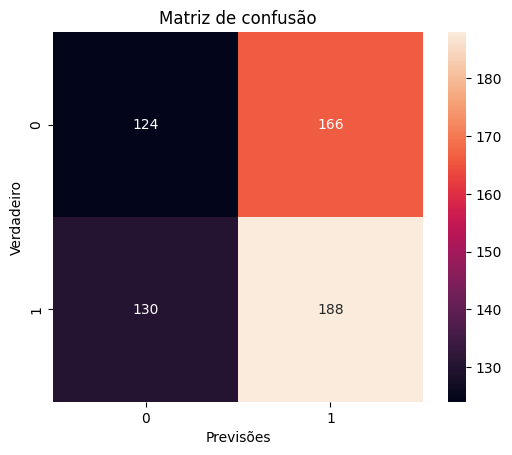

In [9]:
# Criando o NB
model_france_nb = GaussianNB()
model_france_nb.fit(x_train_france, y_train_france)

# Realizando o teste
predicted_model_france_nb = model_france_nb.predict(x_test_france)

accuracia_model_france_nb = accuracy_score(y_test_france, predicted_model_france_nb)
print(f"Acurácia: {(accuracia_model_france_nb * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_france_nb = confusion_matrix(y_test_france, predicted_model_france_nb)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_france_nb, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Serializar
with open('modelos/france/dados_serializados_model_france_nb.pickle', 'wb') as arquivo:
    serializar_assinar(model_france_nb, b'M4Mm]_g#{T', arquivo)
    
    
# desserializar
with open('modelos/france/dados_serializados_model_france_nb.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)


###### Gini

Acurácia: 51.32%


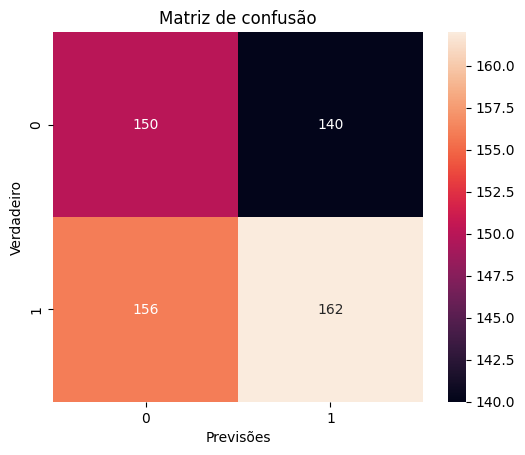

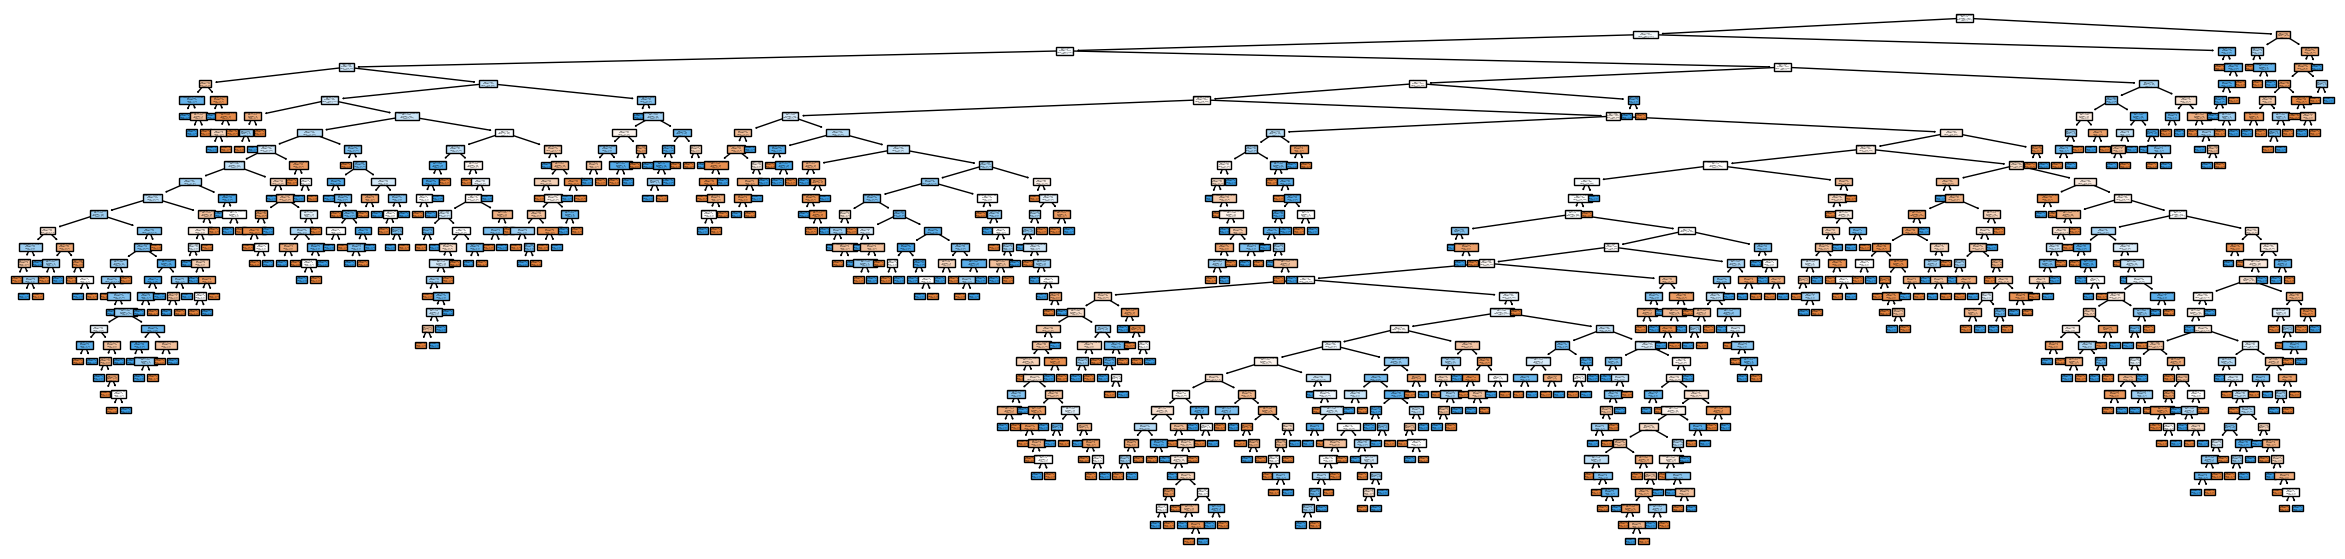

In [10]:
# Criando a arvore de decisao por gini
model_france_gini = tree.DecisionTreeClassifier(criterion='gini')
model_france_gini.fit(x_train_france, y_train_france)

# Realizando o teste
predicted_model_france_gini = model_france_gini.predict(x_test_france)
accuracia_model_france_gini = accuracy_score(y_test_france, predicted_model_france_gini)
print(f"Acurácia: {(accuracia_model_france_gini * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_france_gini = confusion_matrix(y_test_france, predicted_model_france_gini)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_france_gini, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()


# Exibindo a arvore de decisao
class_names_str = [str(cls) for cls in model_france_gini.classes_]
plt.figure(figsize=(30, 7))
plot_tree(model_france_gini,
    feature_names=atributos_france.columns,
    class_names=class_names_str,  
    filled=True)
plt.show()

# Serializar
with open('modelos/france/dados_serializados_model_france_gini.pickle', 'wb') as arquivo:
    serializar_assinar(model_france_gini, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/france/dados_serializados_model_france_gini.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Entropia

Acurácia: 49.18%


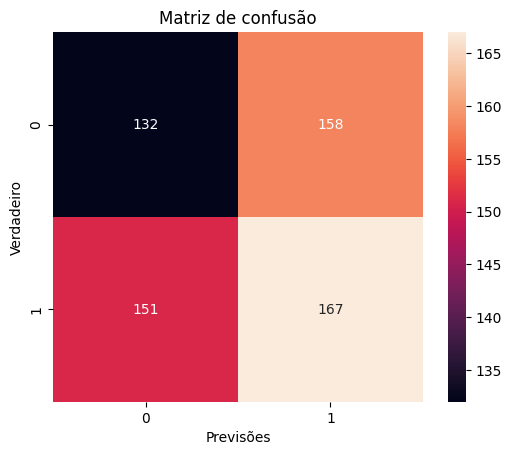

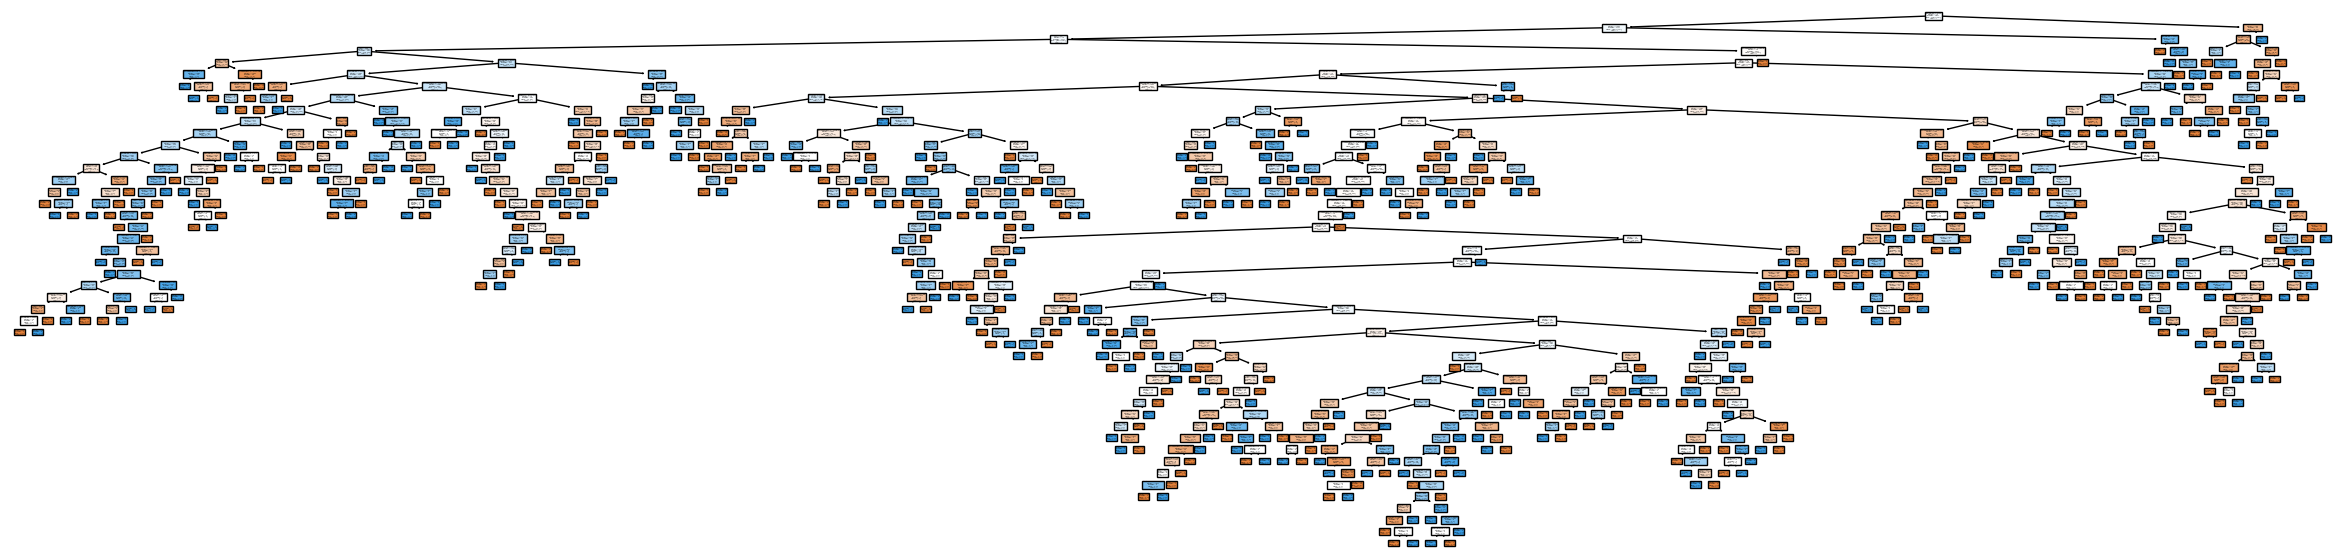

In [11]:
# Criando a arvore de decisao por entropia
model_france_ent = tree.DecisionTreeClassifier(criterion='entropy')
model_france_ent.fit(x_train_france, y_train_france)

# Realizando o teste
predicted_model_france_ent = model_france_ent.predict(x_test_france)
accuracia_model_france_ent = accuracy_score(y_test_france, predicted_model_france_ent)
print(f"Acurácia: {(accuracia_model_france_ent * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_france_ent = confusion_matrix(y_test_france, predicted_model_france_ent)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_france_ent, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Exibindo a arvore de decisao
class_names_str = [str(cls) for cls in model_france_ent.classes_]
plt.figure(figsize=(30, 7))
plot_tree(model_france_ent,
        feature_names=atributos_france.columns,
        class_names=class_names_str,  
        filled=True)
plt.show()

# Serializar
with open('modelos/france/dados_serializados_model_france_ent.pickle', 'wb') as arquivo:
    serializar_assinar(model_france_ent, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/france/dados_serializados_model_france_ent.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Regressao Logistica

c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia: 50.66%


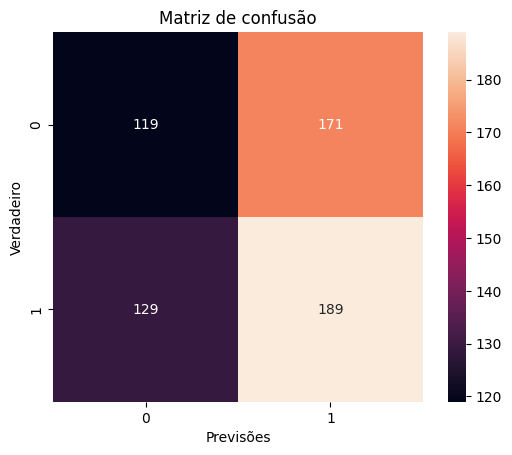

In [12]:
# Criando o modelo
model_france_lr = LogisticRegression()
model_france_lr.fit(x_train_france, y_train_france)

# Realizando o teste
predicted_model_france_lr = model_france_lr.predict(x_test_france)
accuracia_model_france_lr = accuracy_score(y_test_france, predicted_model_france_lr)
print(f"Acurácia: {(accuracia_model_france_lr * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_france_rl = confusion_matrix(y_test_france, predicted_model_france_lr)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_france_rl, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Serializar
with open('modelos/france/dados_serializados_model_france_lr.pickle', 'wb') as arquivo:
    serializar_assinar(model_france_lr, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/france/dados_serializados_model_france_lr.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

### Acurácias France

In [13]:
print(f"Acurácia por Naive Bayes: {(accuracia_model_france_nb * 100):.4f}%")
print(f"Acurácia por Gini: {(accuracia_model_france_gini * 100):.4f}%")
print(f"Acurácia por Entropia: {(accuracia_model_france_ent * 100):.4f}%")
print(f"Acurácia por Regressão Logística: {(accuracia_model_france_lr * 100):.4f}%")

Acurácia por Naive Bayes: 51.3158%
Acurácia por Gini: 51.3158%
Acurácia por Entropia: 49.1776%
Acurácia por Regressão Logística: 50.6579%


### AI - Spain

###### Naive Bayes

Acurácia: 52.80%


c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


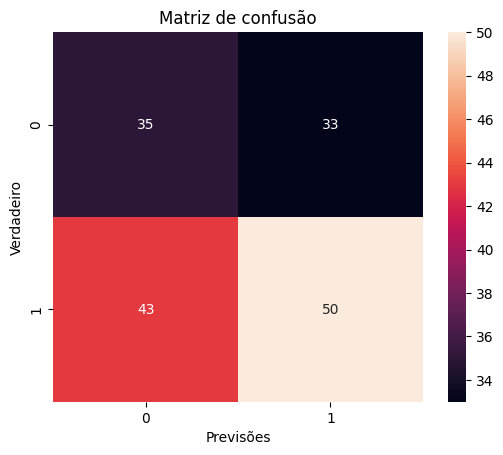

In [14]:
# Criando o NB
model_spain_nb = GaussianNB()
model_spain_nb.fit(x_train_spain, y_train_spain)

# Realizando o teste
predicted_model_spain_nb = model_spain_nb.predict(x_test_spain)

accuracia_model_spain_nb = accuracy_score(y_test_spain, predicted_model_spain_nb)
print(f"Acurácia: {(accuracia_model_spain_nb * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_spain_nb = confusion_matrix(y_test_spain, predicted_model_spain_nb)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_spain_nb, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Serializar
with open('modelos/spain/dados_serializados_model_spain_nb.pickle', 'wb') as arquivo:
    serializar_assinar(model_spain_nb, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/spain/dados_serializados_model_spain_nb.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Gini

Acurácia: 51.55%


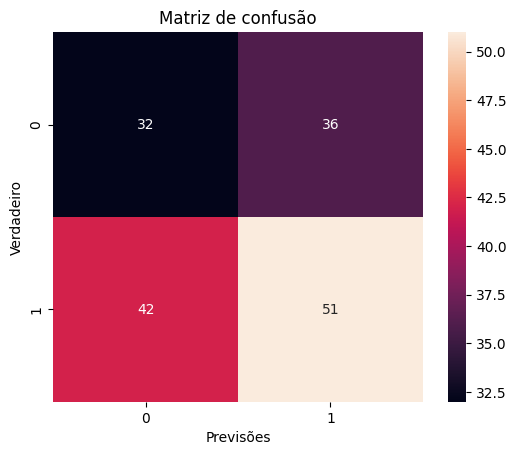

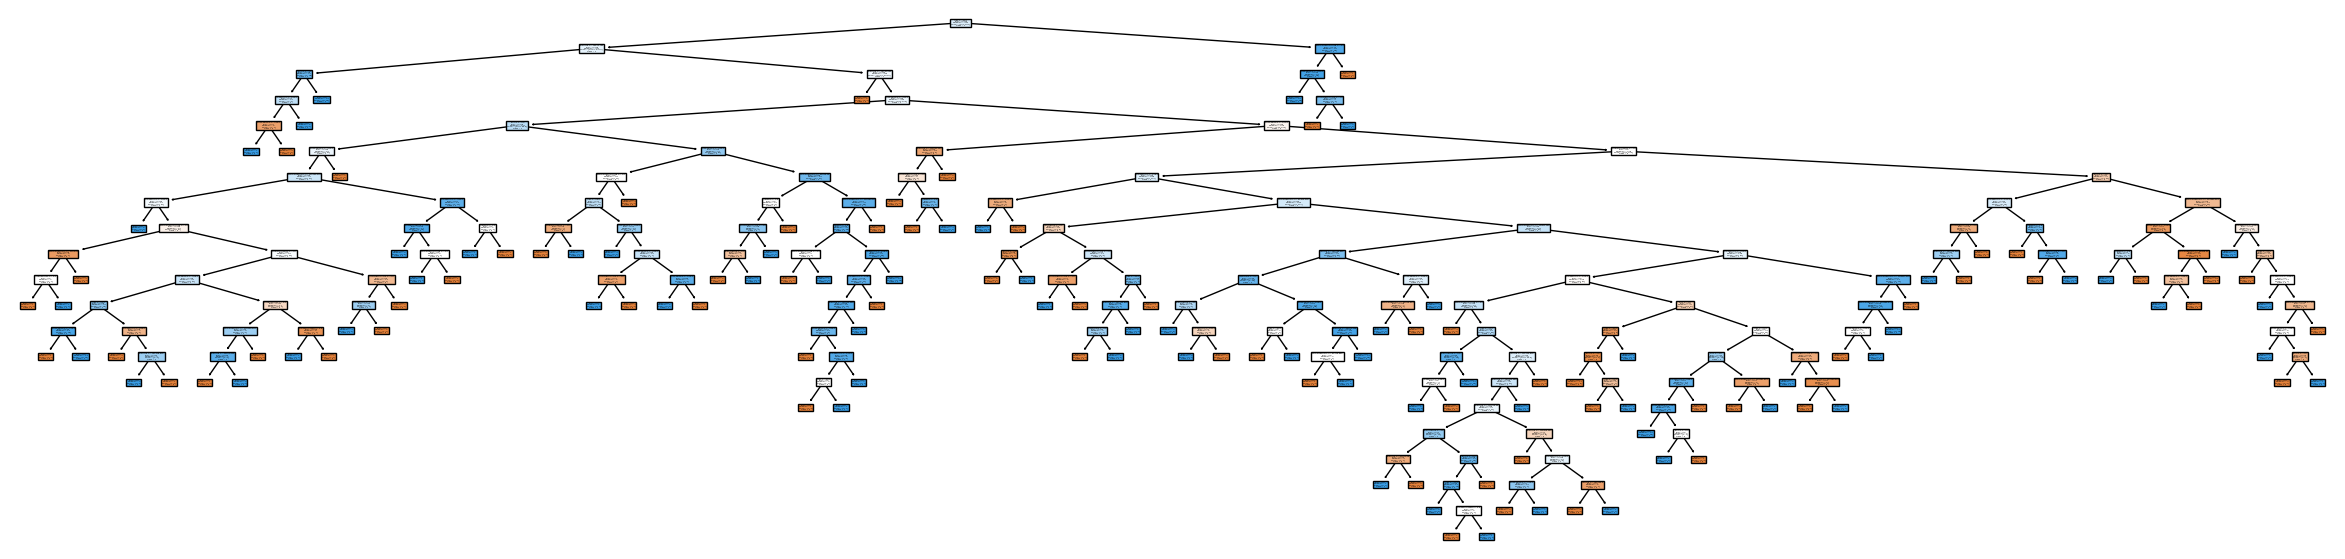

In [15]:
# Criando a arvore de decisao por gini
model_spain_gini = tree.DecisionTreeClassifier(criterion='gini')
model_spain_gini.fit(x_train_spain, y_train_spain)

# Realizando o teste
predicted_model_spain_gini = model_spain_gini.predict(x_test_spain)
accuracia_model_spain_gini = accuracy_score(y_test_spain, predicted_model_spain_gini)
print(f"Acurácia: {(accuracia_model_spain_gini * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_spain_gini = confusion_matrix(y_test_spain, predicted_model_spain_gini)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_spain_gini, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Exibindo a arvore de decisao
class_names_str = [str(cls) for cls in model_spain_gini.classes_]
plt.figure(figsize=(30, 7))
plot_tree(model_spain_gini,
    feature_names=atributos_spain.columns,
    class_names=class_names_str,  
    filled=True)
plt.show()

# Serializar
with open('modelos/spain/dados_serializados_model_spain_gini.pickle', 'wb') as arquivo:
    serializar_assinar(model_spain_gini, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/spain/dados_serializados_model_spain_gini.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Entropia

Acurácia: 50.31%


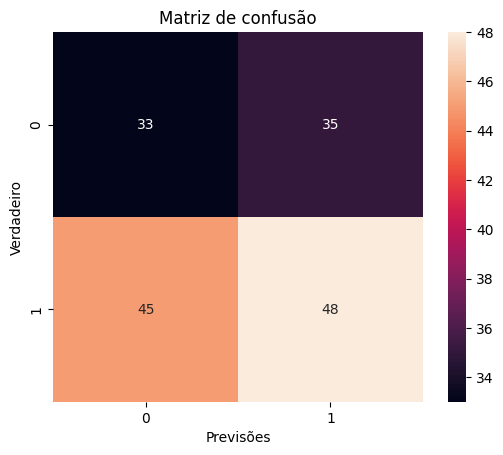

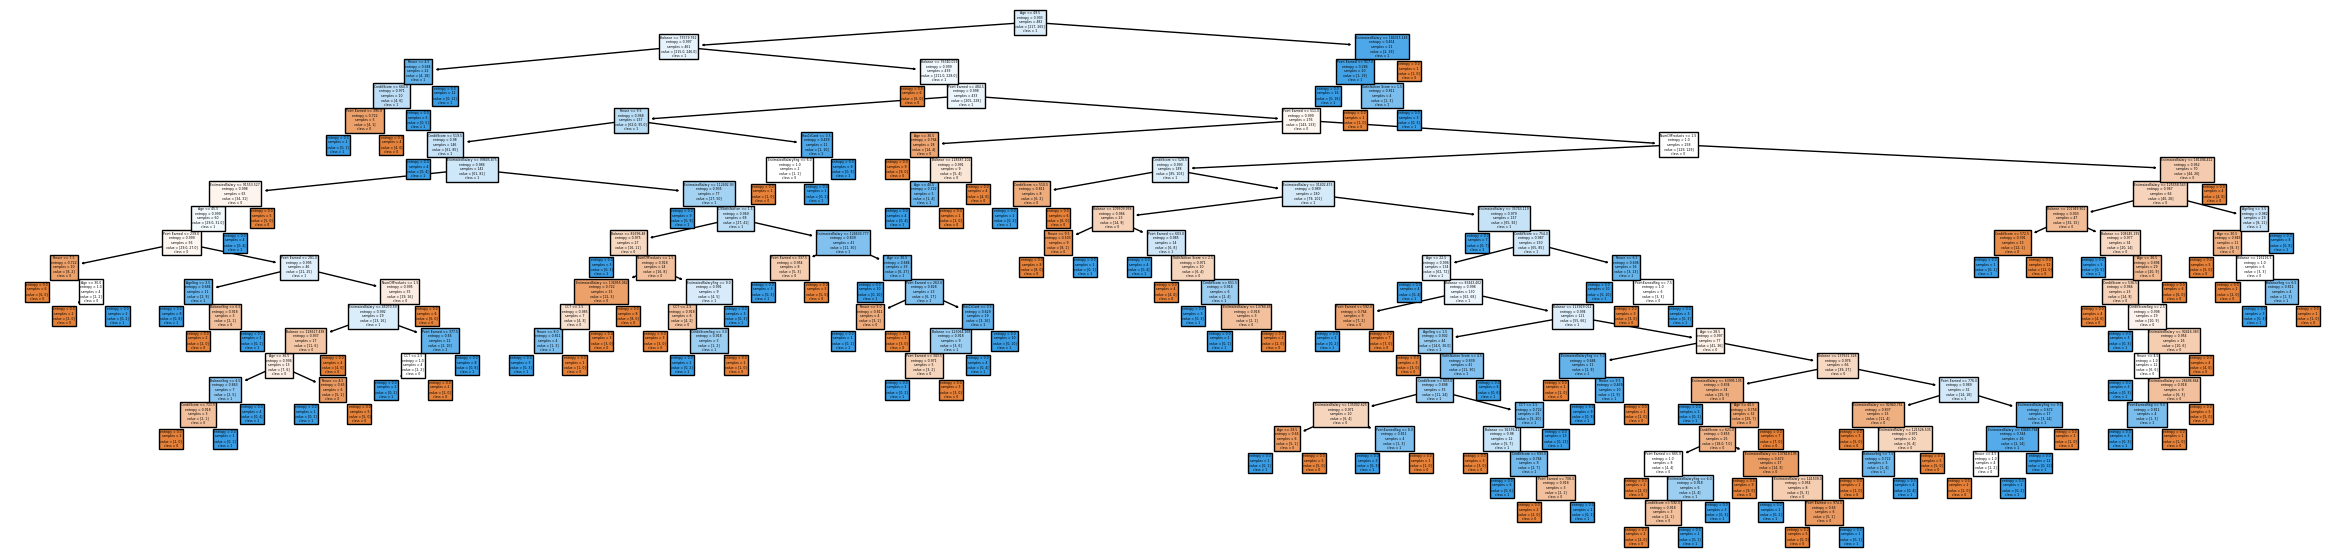

In [16]:
# Criando a arvore de decisao por entropia
model_spain_ent = tree.DecisionTreeClassifier(criterion='entropy')
model_spain_ent.fit(x_train_spain, y_train_spain)

# Realizando o teste
predicted_model_spain_ent = model_spain_ent.predict(x_test_spain)
accuracia_model_spain_ent = accuracy_score(y_test_spain, predicted_model_spain_ent)
print(f"Acurácia: {(accuracia_model_spain_ent * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_spain_ent = confusion_matrix(y_test_spain, predicted_model_spain_ent)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_spain_ent, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Exibindo a arvore de decisao
class_names_str = [str(cls) for cls in model_spain_ent.classes_]
plt.figure(figsize=(30, 7))
plot_tree(model_spain_ent,
        feature_names=atributos_spain.columns,
        class_names=class_names_str,  
        filled=True)
plt.show()

# Serializar
with open('modelos/spain/dados_serializados_model_spain_ent.pickle', 'wb') as arquivo:
    serializar_assinar(model_spain_ent, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/spain/dados_serializados_model_spain_ent.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Regressao Logistica

c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia: 54.04%


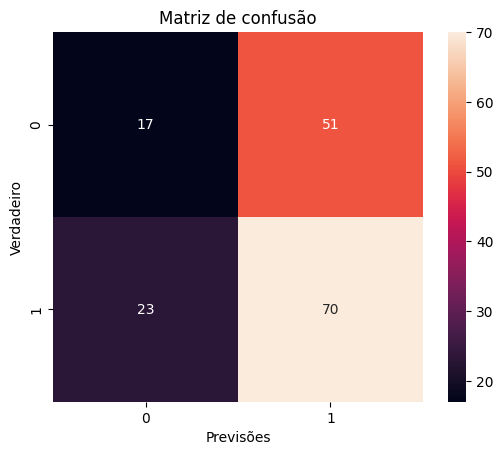

In [17]:
# Criando o modelo
model_spain_lr = LogisticRegression()
model_spain_lr.fit(x_train_spain, y_train_spain)

# Realizando o teste
predicted_model_spain_lr = model_spain_lr.predict(x_test_spain)

accuracia_model_spain_lr = accuracy_score(y_test_spain, predicted_model_spain_lr)
print(f"Acurácia: {(accuracia_model_spain_lr * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_spain_rl = confusion_matrix(y_test_spain, predicted_model_spain_lr)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_spain_rl, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Serializar
with open('modelos/spain/dados_serializados_model_spain_lr.pickle', 'wb') as arquivo:
    serializar_assinar(model_spain_lr, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/spain/dados_serializados_model_spain_lr.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

### Acurárias Spain

In [18]:
print(f"Acurácia por Naive Bayes: {(accuracia_model_spain_nb * 100):.4f}%")
print(f"Acurácia por Gini: {(accuracia_model_spain_gini * 100):.4f}%")
print(f"Acurácia por Entropia: {(accuracia_model_spain_ent * 100):.4f}%")
print(f"Acurácia por Regressão Logística: {(accuracia_model_spain_lr * 100):.4f}%")

Acurácia por Naive Bayes: 52.7950%
Acurácia por Gini: 51.5528%
Acurácia por Entropia: 50.3106%
Acurácia por Regressão Logística: 54.0373%


### IA - Germain

###### Naive Bayes

Acurária: 49.61%


c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


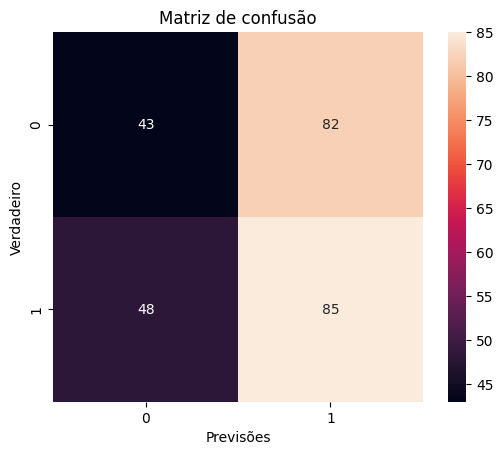

In [19]:
# Criando o NB
model_germany_nb = GaussianNB()
model_germany_nb.fit(x_train_germany, y_train_germany)

# Realizando o teste
predicted_model_germany_nb = model_germany_nb.predict(x_test_germany)

accuracia_model_germany_nb = accuracy_score(y_test_germany, predicted_model_germany_nb)
print(f'Acurária: {(accuracia_model_germany_nb * 100):.2f}%')

# Calculando a matriz de confusao
matriz_confusao_germany_nb = confusion_matrix(y_test_germany, predicted_model_germany_nb)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_germany_nb, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Serializar
with open('modelos/germany/dados_serializados_model_germany_nb.pickle', 'wb') as arquivo:
    serializar_assinar(model_germany_nb, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/germany/dados_serializados_model_germany_nb.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Gini

Acurácia: 51.55%


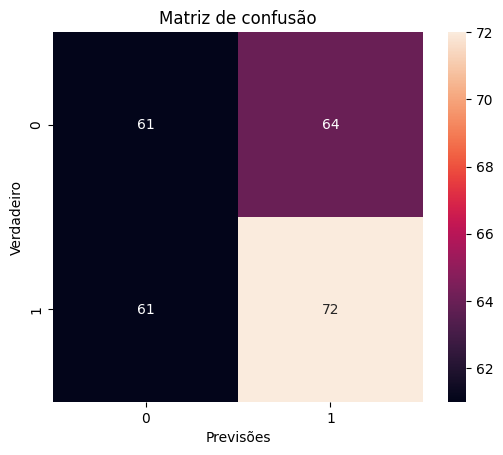

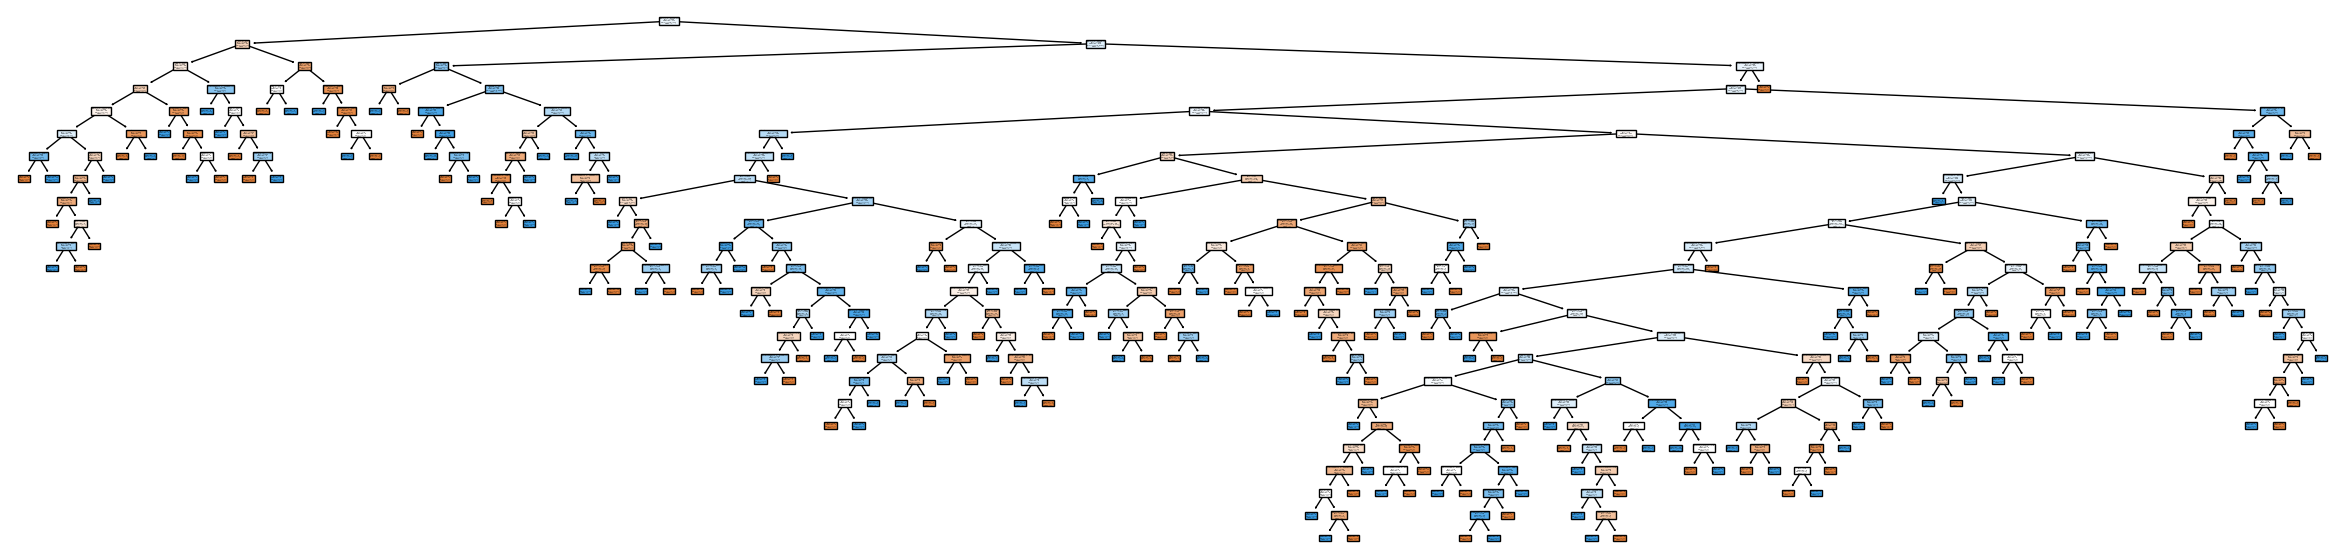

In [20]:
# Criando a arvore de decisao por gini
model_germany_gini = tree.DecisionTreeClassifier(criterion='gini')
model_germany_gini.fit(x_train_germany, y_train_germany)

# Realizando o teste
predicted_model_germany_gini = model_germany_gini.predict(x_test_germany)
accuracia_model_germany_gini = accuracy_score(y_test_germany, predicted_model_germany_gini)
print(f"Acurácia: {(accuracia_model_germany_gini * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_germany_gini = confusion_matrix(y_test_germany, predicted_model_germany_gini)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_germany_gini, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Exibindo a arvore de decisao
class_names_str = [str(cls) for cls in model_germany_gini.classes_]
plt.figure(figsize=(30, 7))
plot_tree(model_germany_gini,
    feature_names=atributos_germany.columns,
    class_names=class_names_str,  
    filled=True)
plt.show()

# Serializar
with open('modelos/germany/dados_serializados_model_germany_gini.pickle', 'wb') as arquivo:
    serializar_assinar(model_germany_gini, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/germany/dados_serializados_model_germany_gini.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Entropia

 Acurácia: 50.00%


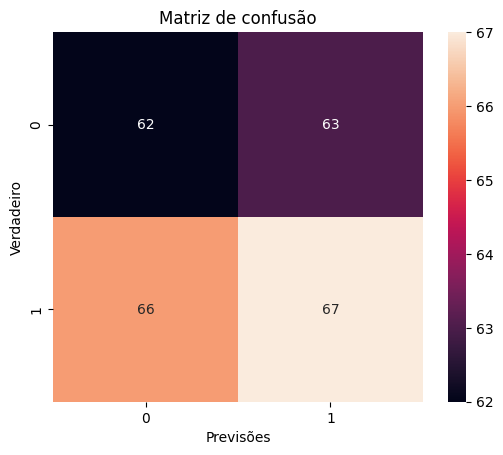

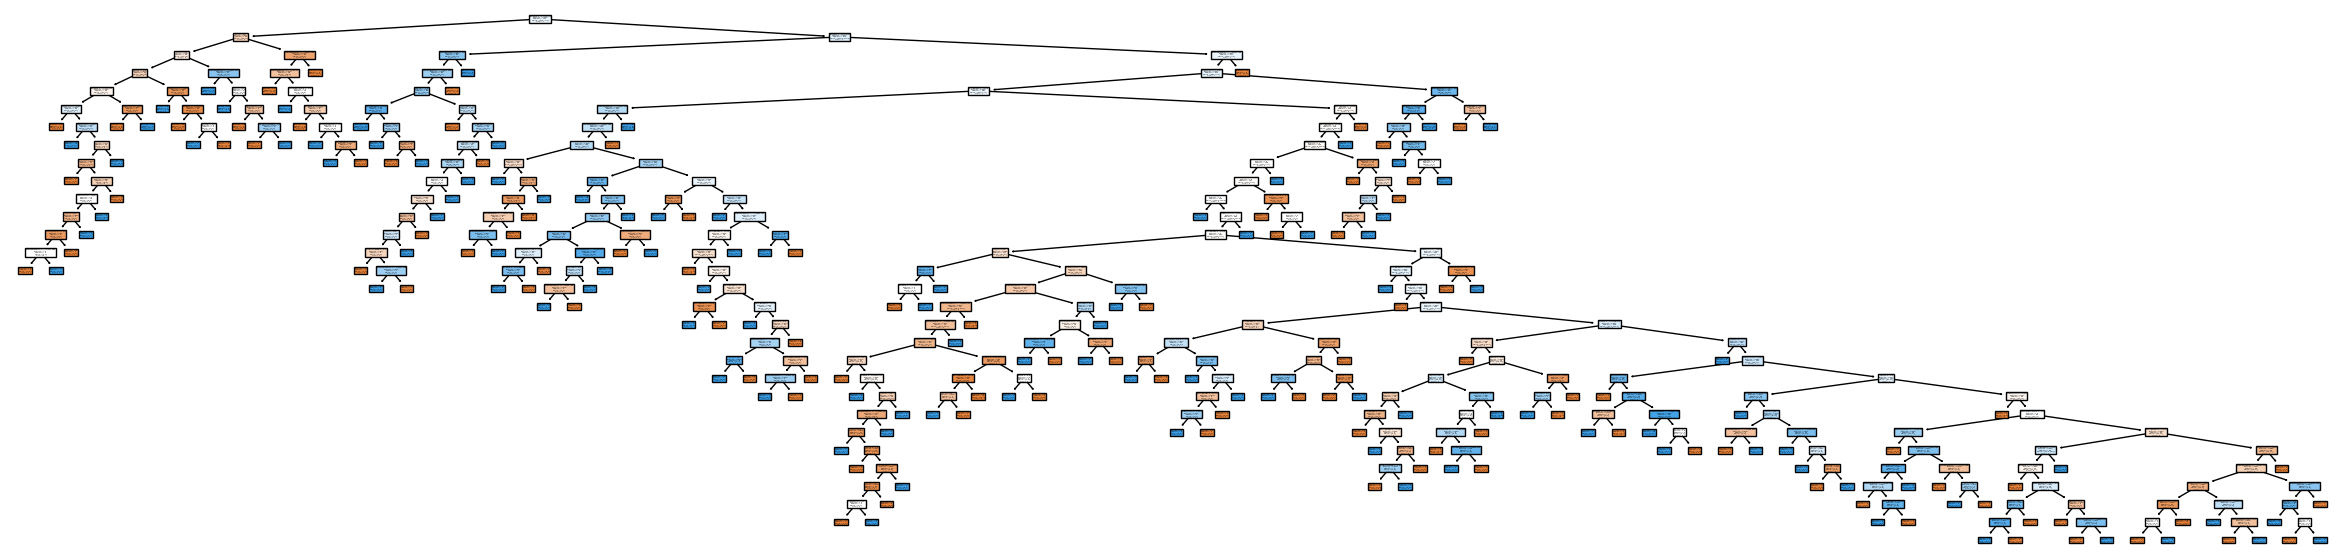

In [21]:
# Criando a arvore de decisao por entropia
model_germany_ent = tree.DecisionTreeClassifier(criterion='entropy')
model_germany_ent.fit(x_train_germany, y_train_germany)

# Realizando o teste
predicted_model_germany_ent = model_germany_ent.predict(x_test_germany)
accuracia_model_germany_ent = accuracy_score(y_test_germany, predicted_model_germany_ent)
print(f' Acurácia: {(accuracia_model_germany_ent * 100):.2f}%')

# Calculando a matriz de confusao
matriz_confusao_germany_ent = confusion_matrix(y_test_germany, predicted_model_germany_ent)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_germany_ent, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Exibindo a arvore de decisao
class_names_str = [str(cls) for cls in model_germany_ent.classes_]
plt.figure(figsize=(30, 7))
plot_tree(model_germany_ent,
        feature_names=atributos_germany.columns,
        class_names=class_names_str,  
        filled=True)
plt.show()

# Serializar
with open('modelos/germany/dados_serializados_model_germany_ent.pickle', 'wb') as arquivo:
    serializar_assinar(model_germany_ent, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/germany/dados_serializados_model_germany_ent.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Regressao Logistica

c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia: 57.75%


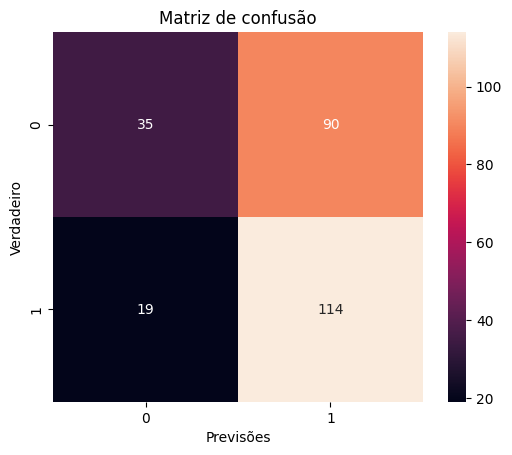

In [22]:
# Criando o modelo
model_germany_lr = LogisticRegression()
model_germany_lr.fit(x_train_germany, y_train_germany)

# Realizando o teste
predicted_model_germany_lr = model_germany_lr.predict(x_test_germany)

accuracia_model_germany_lr = accuracy_score(y_test_germany, predicted_model_germany_lr)
print(f"Acurácia: {(accuracia_model_germany_lr * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_germany_rl = confusion_matrix(y_test_germany, predicted_model_germany_lr)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_germany_rl, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Serializar
with open('modelos/germany/dados_serializados_model_germany_lr.pickle', 'wb') as arquivo:
    serializar_assinar(model_germany_lr, b'M4Mm]_g#{T', arquivo)
    
# desserializar
with open('modelos/germany/dados_serializados_model_germany_lr.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

### Acurácias Germany

In [23]:
print(f'Acurácia por Naive Bayes: {(accuracia_model_germany_nb * 100):.4f}%')
print(f"Acurácia por Gini: {(accuracia_model_germany_gini * 100):.4f}%")
print(f'Acurácia por Entropia: {(accuracia_model_germany_ent * 100):.4f}%')
print(f"Acurácia por Regressão Logística: {(accuracia_model_germany_lr * 100):.4f}%")

Acurácia por Naive Bayes: 49.6124%
Acurácia por Gini: 51.5504%
Acurácia por Entropia: 50.0000%
Acurácia por Regressão Logística: 57.7519%
